<a href="https://colab.research.google.com/github/tirtharajdash/BITS-G513_MetaLearning/blob/main/Lab_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below notebook has been adapted from NYU's Deep Learning Course taught by Yann LeCun & Alfredo Canziani. \[ [Website](https://atcold.github.io/pytorch-Deep-Learning/) ]

# Spiral Classification - Linear vs Non-Linear

## 1. Setup

In [1]:
# Import Libraries

import math
import random
import numpy as np
import torch
from torch import nn, optim
from matplotlib import pyplot as plt
from IPython import display

In [2]:
# Functions to plot the data and model contour

def plot_data(X, y, d=0, auto=False, zoom=1, define_figure=True):
    X = X.cpu()
    y = y.cpu()
    if(define_figure):
        plt.figure(facecolor='#FFFFFF')
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: 
        plt.axis('equal')
    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.figure(facecolor='#FFFFFF')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y, define_figure=False)

In [3]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Creating the Dataset

In [4]:
# Set the seeds

seed = 12345
random.seed(seed)
torch.manual_seed(seed)

In [5]:
# Define the dataset parameters

N = 1000   # num_samples_per_class
D = 2      # dimensions
C = 3      # num_classes

In [6]:
# Generate the Spiral Dataset

X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


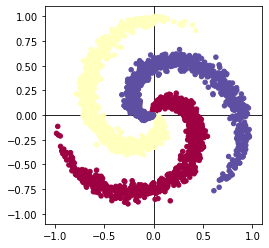

In [7]:
# Visualise the data
plot_data(X, y)

## 3. Training the models

In [8]:
# Define Function to train a model

def train_model(model, criterion, optimizer, train_config, X, y):    
    for epoch in range(train_config['num_epochs']):
        # Feed forward to get the logits
        y_pred = model(X)

        # Compute the loss and accuracy
        loss = criterion(y_pred, y)
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
        display.clear_output(wait=True)

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

In [9]:
H = 100    # num_hidden_units

### 3A - Linear Model

In [10]:
# Set up the model for Training

train_config = {
    'learning_rate': 1e-3,
    'num_epochs': 1000,
    'lambda_l2': 1e-5
}

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=train_config['learning_rate'], 
                            weight_decay=train_config['lambda_l2']) 

In [11]:
# Train the model
train_model(model, criterion, optimizer, train_config, X, y)

[EPOCH]: 999, [LOSS]: 0.861541, [ACCURACY]: 0.504


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


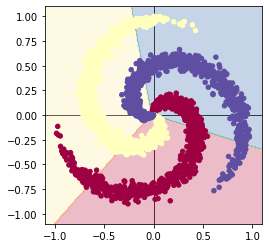

In [12]:
# Plot trained model
print(model)
plot_model(X, y, model)

### 3B - Non-Linear Model

In [13]:
train_config = {
    'learning_rate': 1e-3,
    'num_epochs': 1000,
    'lambda_l2': 1e-5
}

# H = 5
# train_config['num_epochs'] = 10000

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device) #Convert to CUDA

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                            lr=train_config['learning_rate'], 
                            weight_decay=train_config['lambda_l2']) # built-in L2

In [14]:
# Train the model
train_model(model, criterion, optimizer, train_config, X, y)

[EPOCH]: 999, [LOSS]: 0.178409, [ACCURACY]: 0.949


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


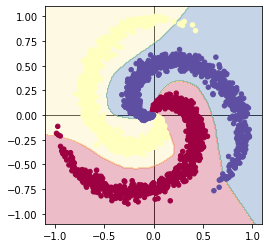

In [15]:
# Plot trained model
print(model)
plot_model(X, y, model)

## 4 - Things to try out
- Try training the above networks using different optimizers and loss functions.
- Experiment with Deeper functions.
- Experiment with the Sigmoid() and Tanh() activation functions.
- Does training for longer help fit the data better for the linear model? 
- Try to see if the network generalizes i.e. if it fits unseen data from the same distribution.